<a href="https://colab.research.google.com/github/liobaDB/DS/blob/main/deepLearning_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Long Short-Term Memory (LSTM)

This example is part of the [*Deep Learning Tutorial*](https://github.com/hfarruda/deeplearningtutorial), authored by Henrique F. de Arruda, Alexandre Benatti, César Comin, and Luciano da Fontoura Costa. This code is not suitable for other data and/or applications, which will require modifications in the structure and parameters. This code has absolutely no warranty.

If you publish a paper related on this material, please cite:

H. F. de Arruda, A. Benatti, C. H. Comin, L. da F. Costa, "Learning Deep Learning (CDT-15)," 2019.

This is the third example of deep learning implementation. Here we use a LSTM network to predict the Bitcoin prices along time by using the input as a temporal series.


First of all, we import the necessary libraries. Here we opt for using Keras (using TensorFlow backend).

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
%tensorflow_version 2.x
import numpy as np
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
#import pandas_datareader
import yfinance as yf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


If you have a GPU, you can use the following code to allocate processing into it.  Otherwise, proceed to (*).

In [8]:
import tensorflow as tf 
from keras import backend as K

#print(K.tensorflow_backend._get_available_gpus())

number_of_cpu_cores = 8
#config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': number_of_cpu_cores}) 
#session = tf.Session(config=config) 
#keras.backend.set_session(session)

(*) Here, we use the Bitcoin daily prices dataset, which is available at
[yhaoo-stock-market](https://finance.yahoo.com/). The data contains seven columns, organized as follows: date, opening stock price, high daily price, low daily price, closing stock price, the currency volume traded on the day, and the adjusted closing price.

In [9]:
train_size = 1500
start_date = '2015-01-01'# Bitcoin started on '2010-07-16'
end_date = '2020-04-01'


tickerData = yf.Ticker("BTC-USD")
dataset = tickerData.history(period='max', interval='1d', start=start_date, end=end_date)
data_oerder = ['Open','High', 'Low', 'Close', 'Volume']
dataset = dataset[data_oerder]


train_dataset = dataset.iloc[0:train_size, 1::].values
test_dataset = dataset.iloc[train_size::, 1::].values

min_max_scaler = MinMaxScaler(feature_range=(0,1))
normalized_train_dataset = min_max_scaler.fit_transform(train_dataset)

min_max_scaler_train = MinMaxScaler(feature_range=(0,1))
normalized_train_price = min_max_scaler_train.fit_transform(train_dataset[:,0:1])


In the following, we define the network topology.

In [10]:
window_size = 50
number_of_lstm_layers = 3
activation = 'sigmoid' 
return_sequences = True
units_first_layer = 100
units = 50

data = []
train_price = []
for i in range(window_size, train_size):
    data.append(normalized_train_dataset[i-window_size:i, 0:5])
    train_price.append(normalized_train_dataset[i, 0])
data, train_price = np.array(data), np.array(train_price)

lstm_model = Sequential()
lstm_model.add(LSTM(units = units_first_layer, 
                    return_sequences = return_sequences, 
                    input_shape = (data.shape[1], 4)))
lstm_model.add(Dropout(0.2))

for i in range(number_of_lstm_layers-2):
    lstm_model.add(LSTM(units = units, return_sequences = return_sequences))
    lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = units))
lstm_model.add(Dropout(0.2))

#Output layer
lstm_model.add(Dense(units = 1, activation = activation))

In order to check the network topology, the subsequent command can be used.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           42000     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            30200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

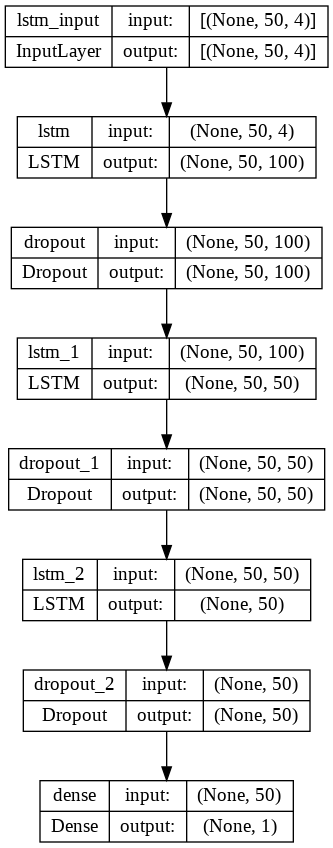

In [11]:
lstm_model.summary() 
#Saving the resultant figure as 'ff_model.png'.
plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True, 
           show_layer_names=True)

The training step is executed as follows.



In [12]:
#Here we set verbose as true
verbose = 1

batch_size = 32
epochs = 10
filepath = 'weights.h5' #name of the file with the network weights
monitor = 'loss'
optimizer = 'adam'
loss = 'mean_squared_error'
metrics = ['mean_absolute_error'] 

lstm_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

early_stopping = EarlyStopping(monitor = monitor, min_delta = 1e-15, 
                               patience = 10, verbose = verbose)
reduce_learning_rate_on_plateau = ReduceLROnPlateau(monitor = monitor, 
                                                    factor = 0.2, patience = 5, 
                                                    verbose = verbose)
model_checkpoint = ModelCheckpoint(filepath = filepath, monitor = monitor, 
                      save_best_only = True, verbose = verbose)
lstm_model.fit(data, train_price, epochs = epochs, batch_size = batch_size,
              callbacks = [early_stopping, reduce_learning_rate_on_plateau, 
              model_checkpoint])

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.0415 - mean_absolute_error: 0.1458
Epoch 1: loss improved from inf to 0.04151, saving model to weights.h5
46/46 [==============================] - 9s 14ms/step - loss: 0.0415 - mean_absolute_error: 0.1458 - lr: 0.0010
Epoch 2/10
44/46 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0402
Epoch 2: loss improved from 0.04151 to 0.00429, saving model to weights.h5
46/46 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_absolute_error: 0.0399 - lr: 0.0010
Epoch 3/10
44/46 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0319
Epoch 3: loss improved from 0.00429 to 0.00282, saving model to weights.h5
46/46 [==============================] - 1s 12ms/step - loss: 0.0028 - mean_absolute_error: 0.0317 - lr: 0.0010
Epoch 4/10
45/46 [============================>.] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0248
Epoch 4: loss improved 

The following code verifies the data in the network.

In [13]:
test_price = test_dataset[:, 0:1]
complete_dataset = dataset.iloc[:,1::]

train_data = complete_dataset[len(complete_dataset) - len(test_dataset) - 
                                 window_size:].values
train_data = min_max_scaler.transform(train_data)


X_test = []
for i in range(window_size,len(train_data)):
    X_test.append(train_data[i-window_size:i, 0:5])
X_test = np.array(X_test)

calculated_prices = lstm_model.predict(X_test)
calculated_prices = min_max_scaler_train.inverse_transform(calculated_prices)

train_price = min_max_scaler_train.inverse_transform([train_price])
train_price = train_price[0]

14/14 [==============================] - 2s 6ms/step


In the following, we plot the train set, as well as the prediction and the expected values.

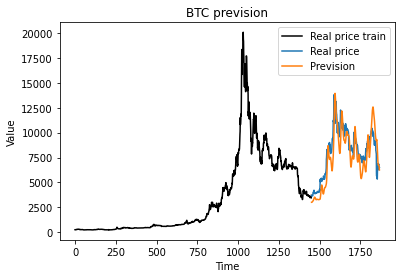

In [14]:
plt.plot(np.linspace(0,len(train_price)-1,len(train_price)), 
         train_price, label = 'Real price train', color = 'k')
plt.plot(np.linspace(len(train_price),len(train_price)+len(test_price)-1,
                     len(test_price)), test_price, label = 'Real price')
plt.plot(np.linspace(len(train_price),len(train_price)+len(test_price)-1,
                     len(test_price)), calculated_prices, label = 'Prevision')
plt.title('BTC prevision')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## License

This Deep Learning Tutorial is licensed under a Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 (CC BY-NC-ND 4.0) International License.

## Acknowledgments
Henrique F. de Arruda acknowledges FAPESP for sponsorship (grant no. 2018/10489-0). H. F. de Arruda also thanks Soremartec S.A. and Soremartec Italia, Ferrero Group, for partial financial support (from 1st July 2021). His funders had no role in study design, data collection, and analysis, decision to publish, or manuscript preparation. Alexandre Benatti thanks Coordenação de Aperfeiçoamento de Pessoal de Nível Superior - Brasil (CAPES) - Finance Code 001. Luciano da F. Costa thanks CNPq (grant no. 307085/2018-0) and FAPESP (proc. 15/22308-2) for sponsorship. César H. Comin thanks FAPESP (Grant Nos. 2018/09125-4 and 2021/12354-8) for financial support. This work has been supported also by FAPESP grants 11/50761-2 and 15/22308-2.